In [0]:
from __future__ import print_function

import os
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K, models
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from skimage.io import imsave
import cv2
from keras.preprocessing.image import ImageDataGenerator

In [0]:
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import os
from keras.preprocessing.image import ImageDataGenerator

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
x_train_path = '/content/drive/My Drive/Colab Notebooks/Training/original_retinal_images/'
y_train_path = '/content/drive/My Drive/Colab Notebooks/Training/blood_vessel_segmentation_masks/'
x_test_path = '/content/drive/My Drive/Colab Notebooks/Test/original_retinal_images/'
y_test_path = '/content/drive/My Drive/Colab Notebooks/Test/blood_vessel_segmentation_masks/'

In [0]:
def read_data(path):
    image_names = sorted(os.listdir(path))
    #print(image_names)
    l = []
    for i in range(len(image_names)):
        tmp = cv2.imread(path + image_names[i], 0)
        l.append(tmp)

    return np.asanyarray(l)

In [0]:
x_train = read_data(x_train_path)
y_train = read_data(y_train_path)
x_test = read_data(x_test_path)
y_test = read_data(y_test_path)

x_train = np.expand_dims(x_train, axis=3)
y_train = np.expand_dims(y_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
y_test = np.expand_dims(y_test, axis=3)

In [0]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(20, 512, 512, 1) (20, 512, 512, 1) (20, 512, 512, 1) (20, 512, 512, 1)


In [0]:
smooth = 1.
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall))

In [0]:
def get_segnet(input_size = (512,512,1)):
    kernel = 3

    encoding_layers = [
        Conv2D(32, (kernel, kernel), padding='same', input_shape=input_size),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(32, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        MaxPooling2D(),

        Conv2D(64, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(64, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        MaxPooling2D(),

        Conv2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        MaxPooling2D(),

        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        MaxPooling2D(),

        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        MaxPooling2D(),
    ]

    autoencoder = models.Sequential()
    autoencoder.encoding_layers = encoding_layers

    for l in autoencoder.encoding_layers:
        autoencoder.add(l)

    decoding_layers = [
        UpSampling2D(size=(2, 2)),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),

        UpSampling2D(size=(2, 2)),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),

        UpSampling2D(size=(2, 2)),
        Conv2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(64, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        UpSampling2D(size=(2, 2)),
        Conv2D(64, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(32, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),

        UpSampling2D(size=(2, 2)),
        Conv2D(32, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),

        Conv2D(1, (1, 1), padding='valid'),
        BatchNormalization(axis=3),
    ]
    autoencoder.decoding_layers = decoding_layers
    for l in autoencoder.decoding_layers:
        autoencoder.add(l)

    autoencoder.add(Activation('sigmoid'))
    autoencoder.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4),
                        metrics=[dice_coef, 'accuracy', precision, recall, f1score])
    autoencoder.summary()

    return autoencoder

In [0]:
model = get_segnet()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 512, 512, 32)      320       
_________________________________________________________________
batch_normalization_27 (Batc (None, 512, 512, 32)      128       
_________________________________________________________________
activation_27 (Activation)   (None, 512, 512, 32)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 512, 512, 32)      9248      
_________________________________________________________________
batch_normalization_28 (Batc (None, 512, 512, 32)      128       
_________________________________________________________________
activation_28 (Activation)   (None, 512, 512, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 256, 256, 32)     

In [0]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/segnet_task_2.hdf5')

In [0]:
tmp = model.predict(x_test)

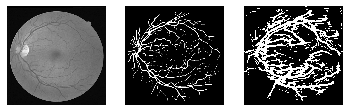

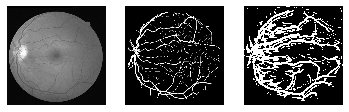

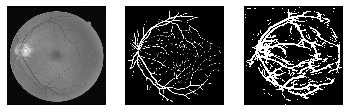

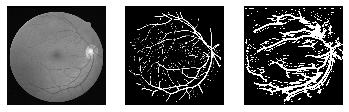

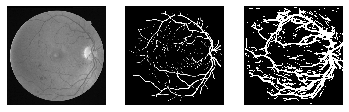

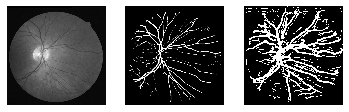

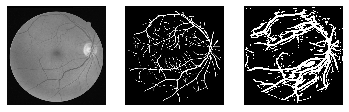

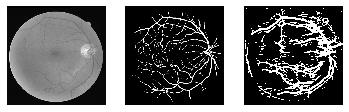

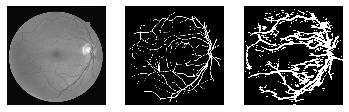

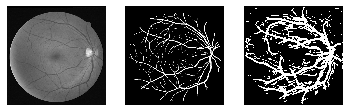

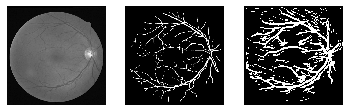

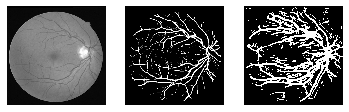

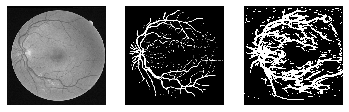

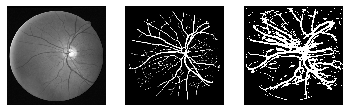

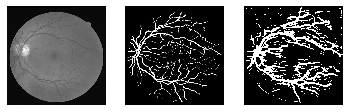

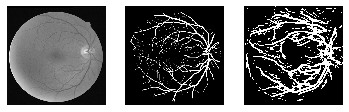

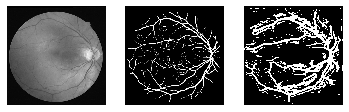

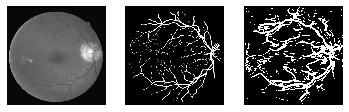

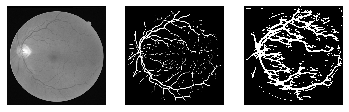

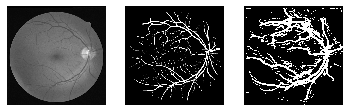

In [0]:
save_path = "/content/drive/My Drive/Colab Notebooks/Test/segnet_prediction/"
for i in range(len(x_test)):
    f = plt.figure()
    f.add_subplot(1,3, 1)
    plt.imshow(x_test[i].reshape((512,512)), cmap = 'gray')
    plt.axis('off')
    f.add_subplot(1,3, 2)
    plt.imshow(y_test[i].reshape((512,512)), cmap = 'gray')
    plt.axis('off')
    f.add_subplot(1,3, 3)
    a = tmp[i].copy()
    a[a > 0.9] = 1
    a[a <= 0.9] = 0
    plt.imshow(a.reshape((512,512)), cmap = 'gray')
    plt.axis('off')
    plt.show(block=True)

    plt.imsave(save_path + f"{10+i}_ground.png", y_test[i].reshape((512,512)), cmap = 'gray')
    plt.imsave(save_path + f"{10+i}_predict.png", a.reshape((512,512)), cmap = 'gray')

In [0]:
tmp = model.predict(x_train)

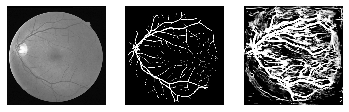

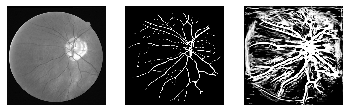

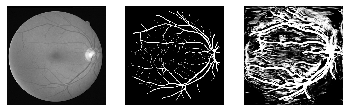

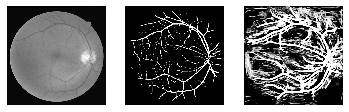

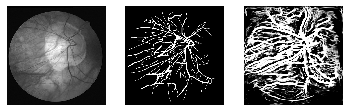

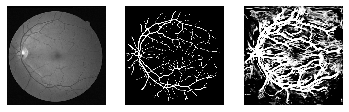

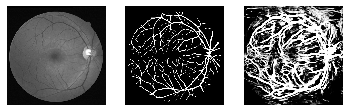

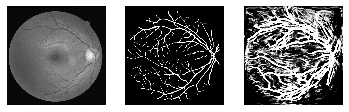

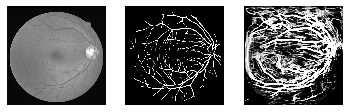

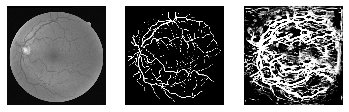

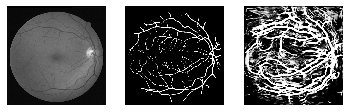

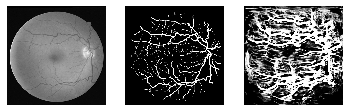

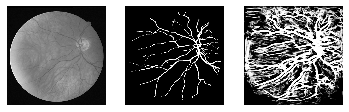

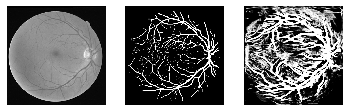

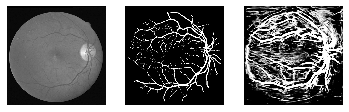

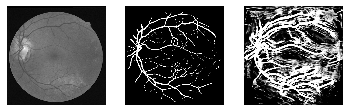

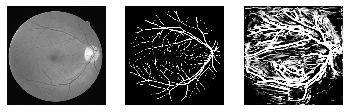

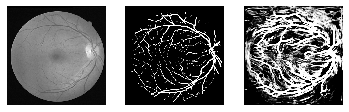

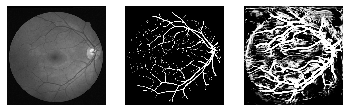

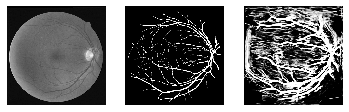

In [0]:
for i in range(len(x_train)):
    f = plt.figure()
    f.add_subplot(1,3, 1)
    plt.imshow(x_train[i].reshape((512,512)), cmap = 'gray')
    plt.axis('off')
    f.add_subplot(1,3, 2)
    plt.imshow(y_train[i].reshape((512,512)), cmap = 'gray')
    plt.axis('off')
    f.add_subplot(1,3, 3)
    plt.imshow(tmp[i].reshape((512,512)), cmap = 'gray')
    plt.axis('off')
    plt.show(block=True)